<a href="https://colab.research.google.com/github/Aliharis007/Word-Embeddings/blob/main/Word_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving text_corpus.txt to text_corpus.txt


In [ ]:
with open('text_corpus.txt', 'r') as f:
    text = f.read().lower()
print(text)


deep learning is amazing. machine learning is powerful. ai is the future.
computers can learn from data. data is crucial for ai.



In [ ]:
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

tokens = word_tokenize(text)
tokens = [word for word in tokens if word not in stop_words and word not in string.punctuation]

print(tokens)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['deep', 'learning', 'amazing', 'machine', 'learning', 'powerful', 'ai', 'future', 'computers', 'learn', 'data', 'data', 'crucial', 'ai']


In [ ]:
vocab = sorted(set(tokens))
word2idx = {word: idx for idx, word in enumerate(vocab)}
idx2word = {idx: word for word, idx in word2idx.items()}

print("Vocab size:", len(vocab))


Vocab size: 11


In [ ]:
def generate_skipgram_pairs(tokens, window_size=2):
    pairs = []
    for idx, target in enumerate(tokens):
        for offset in range(-window_size, window_size + 1):
            context_idx = idx + offset
            if context_idx >= 0 and context_idx < len(tokens) and context_idx != idx:
                pairs.append((target, tokens[context_idx]))
    return pairs

skipgram_pairs = generate_skipgram_pairs(tokens, window_size=2)
print(skipgram_pairs[:10])


[('deep', 'learning'), ('deep', 'amazing'), ('learning', 'deep'), ('learning', 'amazing'), ('learning', 'machine'), ('amazing', 'deep'), ('amazing', 'learning'), ('amazing', 'machine'), ('amazing', 'learning'), ('machine', 'learning')]


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SkipGramModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGramModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.output_layer = nn.Linear(embedding_dim, vocab_size)

    def forward(self, input_word):
        embed = self.embeddings(input_word)
        out = self.output_layer(embed)
        return out


In [ ]:
import random

embedding_dim = 10
learning_rate = 0.01
epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SkipGramModel(len(vocab), embedding_dim).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

pairs_idx = [(word2idx[target], word2idx[context]) for target, context in skipgram_pairs]

for epoch in range(epochs):
    total_loss = 0
    random.shuffle(pairs_idx)
    for target_idx, context_idx in pairs_idx:
        input_tensor = torch.tensor([target_idx], dtype=torch.long).to(device)
        target_tensor = torch.tensor([context_idx], dtype=torch.long).to(device)

        optimizer.zero_grad()
        output = model(input_tensor)
        loss = loss_fn(output, target_tensor)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")


Epoch 10/100, Loss: 107.1393
Epoch 20/100, Loss: 98.4845
Epoch 30/100, Loss: 92.3397
Epoch 40/100, Loss: 87.3514
Epoch 50/100, Loss: 83.4436
Epoch 60/100, Loss: 80.4566
Epoch 70/100, Loss: 78.1629
Epoch 80/100, Loss: 76.3460
Epoch 90/100, Loss: 74.9522
Epoch 100/100, Loss: 73.8833


In [ ]:
embeddings = model.embeddings.weight.data.cpu().numpy()


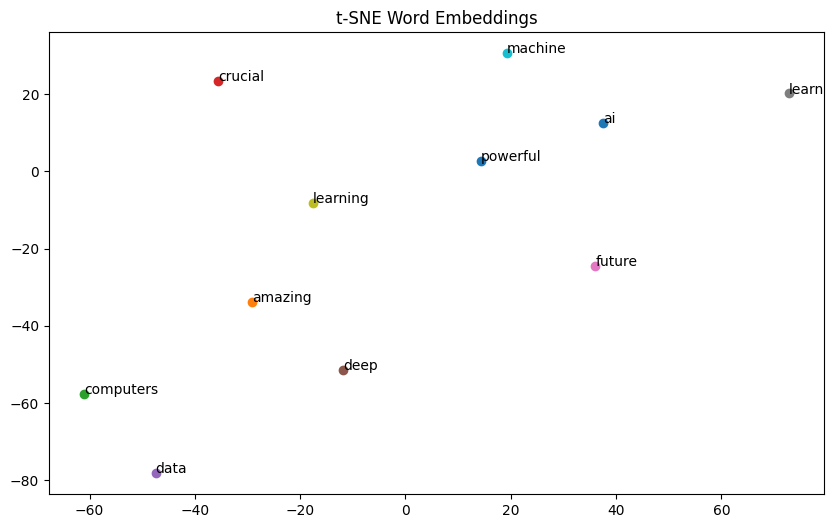

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=0, perplexity=5)
reduced_embeddings = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 6))
for i, word in enumerate(vocab):
    x, y = reduced_embeddings[i]
    plt.scatter(x, y)
    plt.annotate(word, (x, y))
plt.title("t-SNE Word Embeddings")
plt.show()

NOW WORKING FOR CBOW TASK 5

In [ ]:
def generate_cbow_pairs(tokens, window_size=2):
    pairs = []
    for idx in range(window_size, len(tokens) - window_size):
        context = [tokens[i] for i in range(idx - window_size, idx + window_size + 1) if i != idx]
        target = tokens[idx]
        pairs.append((context, target))
    return pairs

cbow_pairs = generate_cbow_pairs(tokens, window_size=2)
print(cbow_pairs[:5])


[(['deep', 'learning', 'machine', 'learning'], 'amazing'), (['learning', 'amazing', 'learning', 'powerful'], 'machine'), (['amazing', 'machine', 'powerful', 'ai'], 'learning'), (['machine', 'learning', 'ai', 'future'], 'powerful'), (['learning', 'powerful', 'future', 'computers'], 'ai')]


In [ ]:
cbow_pairs_idx = [([word2idx[w] for w in context], word2idx[target]) for context, target in cbow_pairs]


In [ ]:
class CBOWModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOWModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)

    def forward(self, context_idxs):
        embeds = self.embeddings(context_idxs)
        hidden = embeds.mean(dim=0).view(1, -1)
        out = self.linear(hidden)
        return out


In [ ]:
embedding_dim = 10
cbow_model = CBOWModel(len(vocab), embedding_dim).to(device)
optimizer = torch.optim.SGD(cbow_model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

epochs = 100

for epoch in range(epochs):
    total_loss = 0
    random.shuffle(cbow_pairs_idx)
    for context_idxs, target_idx in cbow_pairs_idx:
        context_tensor = torch.tensor(context_idxs, dtype=torch.long).to(device)
        target_tensor = torch.tensor([target_idx], dtype=torch.long).to(device)

        optimizer.zero_grad()
        output = cbow_model(context_tensor)
        loss = loss_fn(output, target_tensor)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


Epoch 10, Loss: 21.3407
Epoch 20, Loss: 19.6235
Epoch 30, Loss: 18.1152
Epoch 40, Loss: 16.7568
Epoch 50, Loss: 15.5145
Epoch 60, Loss: 14.3690
Epoch 70, Loss: 13.3094
Epoch 80, Loss: 12.3279
Epoch 90, Loss: 11.4197
Epoch 100, Loss: 10.5800


In [ ]:
cbow_embeddings = cbow_model.embeddings.weight.data.cpu().numpy()


**WORD ANALOGY:**

In [ ]:
import numpy as np

def find_analogy(word_a, word_b, word_c, embeddings, word2idx, idx2word):
    vec_a = embeddings[word2idx[word_a]]
    vec_b = embeddings[word2idx[word_b]]
    vec_c = embeddings[word2idx[word_c]]

    target_vec = vec_b - vec_a + vec_c

    similarities = []
    for i in range(len(embeddings)):
        similarity = np.dot(target_vec, embeddings[i]) / (np.linalg.norm(target_vec) * np.linalg.norm(embeddings[i]))
        similarities.append((idx2word[i], similarity))

    similarities = sorted(similarities, key=lambda x: -x[1])
    for word, score in similarities[:5]:
        print(f"{word}: {score:.4f}")

find_analogy("machine", "learning", "data", cbow_embeddings, word2idx, idx2word)


data: 0.5273
powerful: 0.4352
learning: 0.3566
learn: 0.2367
computers: 0.1792


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


In [ ]:
tsne = TSNE(n_components=2, random_state=42, perplexity=3)
cbow_2d = tsne.fit_transform(cbow_embeddings)


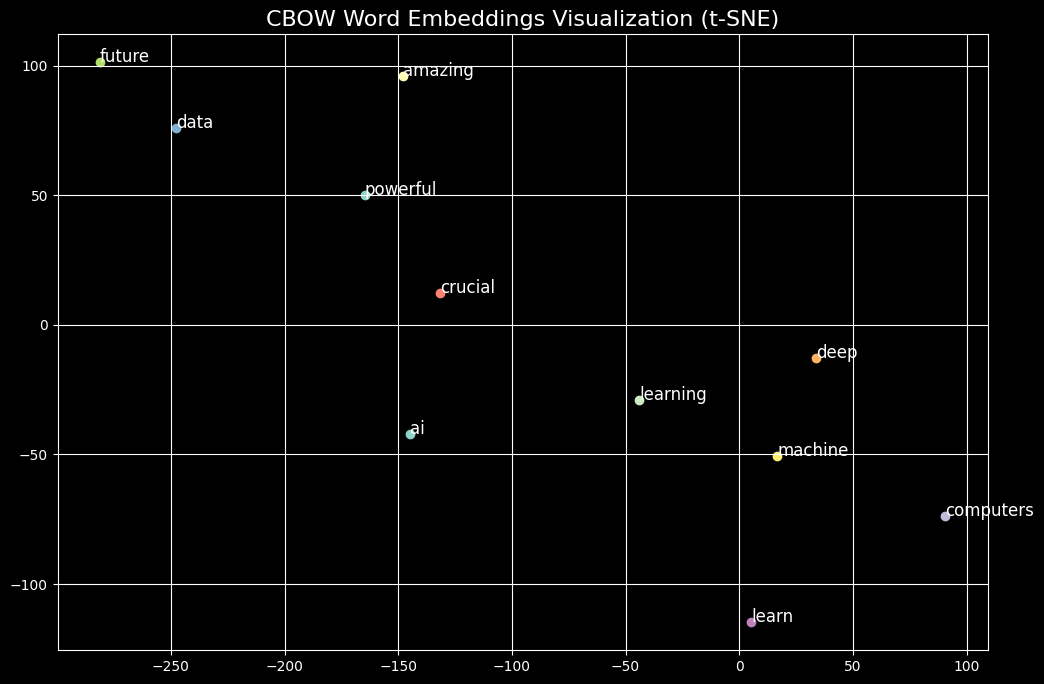

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

word2idx = {word: idx for idx, word in enumerate(vocab)}

tsne = TSNE(n_components=2, random_state=42, perplexity=3)
cbow_2d = tsne.fit_transform(cbow_embeddings)

plt.figure(figsize=(12, 8))
for i, label in enumerate(word2idx.keys()):
    x, y = cbow_2d[i, 0], cbow_2d[i, 1]
    plt.scatter(x, y)
    plt.annotate(label, (x, y), fontsize=12)

plt.title("CBOW Word Embeddings Visualization (t-SNE)", fontsize=16)
plt.grid(True)
plt.show()